In [4]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from ultralytics import YOLO
import json
import xml.etree.ElementTree as ET
import os
import cv2 as cv
from sklearn.model_selection import train_test_split
import random
import re
from PIL import Image
from shutil import move
from shutil import copy2
import glob
import albumentations as A

C:\Users\user\AppData\Roaming\Python\Python38\site-packages\albumentations\__init__.py:13: UserWarning: A new version of Albumentations is available: 2.0.6 (you have 1.4.18). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [11]:
tf.keras.backend.clear_session()
physical_devices = tf.config.list_physical_devices('GPU') 
for gpu_instance in physical_devices: 
    tf.config.experimental.set_memory_growth(gpu_instance, True)

In [21]:
import xml.etree.ElementTree as ET

def process_xml_files(folder_path):
    bbox_results = {}
    
    # Get the list of all XML files in the folder
    xml_file_list = [file for file in os.listdir(folder_path) if file.endswith('.xml')]
    
    for xml_file in xml_file_list:
        xml_path = os.path.join(folder_path, xml_file)
        try:
            tree = ET.parse(xml_path)
        except FileNotFoundError:
            print(f"File not found: {xml_path}")
            continue
        
        root = tree.getroot()
        bbox_results[xml_file] = []
        
        # Extract bounding boxes (XPath may vary based on your XML structure)
        for obj in root.findall('object'):
            class_name = obj.find('name').text if obj.find('name') is not None else "unknown"
            bbox = obj.find('bndbox')
            if bbox is not None:
                xmin = int(bbox.find('xmin').text)
                ymin = int(bbox.find('ymin').text)
                xmax = int(bbox.find('xmax').text)
                ymax = int(bbox.find('ymax').text)
                bbox_info = {
                    "class": [class_name],
                    "bbox": [xmin, ymin, xmax, ymax]
                }
                bbox_results[xml_file].append(bbox_info)
    
    return bbox_results

# Update the paths to your folders containing XML files
train_folder = "S2TLD/normal_2/Annotations"
test_folder = "S2TLD/normal_1/Annotations"

train_data = process_xml_files(train_folder)
test_data = process_xml_files(test_folder)

print("Processed train files:", len(train_data))
print("Processed test files:", len(test_data))

Processed train files: 3785
Processed test files: 779


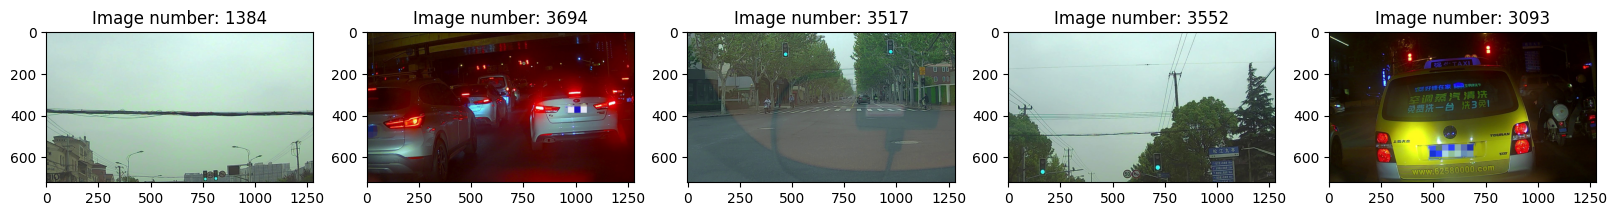

In [9]:
fig, ax=plt.subplots(ncols=5,figsize=(20,20))
for i in range(5):
    # files = [f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f))]
    # random_file = random.choice(files)
    x=random.randrange(779,3785)
    z=str(x).zfill(6)
    path=(f'S2TLD/normal_2/JPEGImages/{z}.jpg')
    img=cv.imread(path)
    ax[i].imshow(cv.cvtColor(img,cv.COLOR_BGR2RGB))
    ax[i].title.set_text(f'Image number: {x}')

In [24]:
class_mapping = {
    "red": 0,
    "yellow": 1,
    "green": 2,
    "off": 3
}


In [25]:
def get_yolo(data,t="train"):
    #annotation_folder = f"Dataset/annotations/{t}/labels" 
    if t == 'train':
        annotation_folder = "Dataset/train/labels"  # Output folder for YOLO annotation files
    else:
        annotation_folder = "Dataset/test/labels"  
        
    os.makedirs(annotation_folder, exist_ok=True)
    for image_name, objects in data.items():
        img_name=re.split('\.',image_name)[0]
        width, height =1280,720
        annotation_file = os.path.join(annotation_folder, os.path.splitext(image_name)[0] + ".txt")
        with open(annotation_file, "w") as f:
            for obj in objects:
                class_name = obj["class"]  # Assuming objects include a "class" key
                if isinstance(class_name, list):  # Check if class_name is a list
                    class_name = class_name[0]  # Extract the first element
                
                class_id = class_mapping.get(class_name, -1)  # Default to -1 if class_name is not found
                
                xmin, ymin, xmax, ymax = obj["bbox"]
    
                # Convert to YOLO format (normalized values)
                x_center = (xmin + xmax) / 2 / width
                y_center = (ymin + ymax) / 2 / height
                bbox_width = (xmax - xmin) / width
                bbox_height = (ymax - ymin) / height
    
                # Write to file
                f.write(f"{class_id} {x_center:.6f} {y_center:.6f} {bbox_width:.6f} {bbox_height:.6f}\n")

In [26]:
get_yolo(train_data)

In [15]:
get_yolo(test_data,'test')

In [28]:
images_folder = 'S2TLD/normal_2/JPEGImages'
annotations_folder = "Dataset/train/labels"
train_folder = 'Dataset/train/images'


os.makedirs(train_folder, exist_ok=True)

for filename in os.listdir(images_folder):
    src_path = os.path.join(images_folder, filename)  # Construct full file path
    dst_path = os.path.join(train_folder, filename)
    copy2(src_path, dst_path)


images_folder = 'Dataset/train/images'

# Function to get the list of all images and annotations
def get_files(folder_path):
    return [os.path.join(folder_path, f) for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f))]

# Get the list of images and annotations
image_files = get_files(images_folder)
annotation_files = get_files(annotations_folder)

# Split data into training and validation sets
train_images, val_images, train_annotations, val_annotations = train_test_split(
    image_files, annotation_files, test_size=0.2, random_state=42
)

# Paths for saving validation data
validation_images_folder = "Dataset/val/images"
validation_annotations_folder = "Dataset/val/labels"

os.makedirs(validation_images_folder, exist_ok=True)
os.makedirs(validation_annotations_folder, exist_ok=True)

# Function to copy files into validation folders

        
def move_to_validation(files, destination_folder):
    for file_path in files:
        move(file_path, destination_folder)

move_to_validation(val_images, validation_images_folder)
move_to_validation(val_annotations, validation_annotations_folder)

print("Data has been successfully split!")


Data has been successfully split!


In [1]:
def count_classes(labels_dir):
    class_counts = {0: 0, 1: 0, 2: 0, 3: 0}
    
    for label_file in glob.glob(os.path.join(labels_dir, "*.txt")):
        with open(label_file, 'r') as f:
            for line in f:
                class_id = int(line.strip().split()[0])
                class_counts[class_id] += 1
    
    return class_counts

# Check train dataset
train_counts = count_classes("Dataset/train/labels")
print("Training set class distribution:", train_counts)

# Check validation dataset
val_counts = count_classes("Dataset/val/labels")
print("Validation set class distribution:", val_counts)

Training set class distribution: {0: 4559, 1: 129, 2: 2758, 3: 325}
Validation set class distribution: {0: 1153, 1: 26, 2: 697, 3: 69}


In [29]:
import albumentations as A
import cv2
import os
import numpy as np

# Define augmentation pipeline
transform = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.5),
    A.Rotate(limit=10, p=0.5),
    A.RandomScale(scale_limit=0.1, p=0.5),
    A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.05, rotate_limit=10, p=0.5),
],
    bbox_params=A.BboxParams(format='yolo', label_fields=['labels'])
)

def augment_minority_classes(images_dir, labels_dir, output_images_dir, output_labels_dir, class_id, augmentation_factor):
    os.makedirs(output_images_dir, exist_ok=True)
    os.makedirs(output_labels_dir, exist_ok=True)
    
    # Collect all label files containing the minority class
    minority_files = []
    for label_file in os.listdir(labels_dir):
        if not label_file.endswith('.txt'):
            continue
        label_path = os.path.join(labels_dir, label_file)
        with open(label_path, 'r') as f:
            for line in f:
                class_val = line.strip().split()[0]
                if int(float(class_val)) == class_id:
                    minority_files.append(label_file.replace('.txt', ''))
                    break
    
    # Augment each image containing the minority class
    for file_base in minority_files:
        img_path = os.path.join(images_dir, file_base + '.jpg').replace("\\", "/")
        label_path = os.path.join(labels_dir, file_base + '.txt').replace("\\", "/")
        
        img = cv2.imread(img_path)
        if img is None:
            print(f"Warning: Image {img_path} not found or unreadable.")
            continue
        height, width = img.shape[:2]
        
        # Read bounding boxes
        with open(label_path, 'r', encoding='utf-8') as f:
            labels = [line.strip() for line in f]
        
        bboxes = []
        class_ids = []
        for label in labels:
            parts = label.split()
            cls_id = int(parts[0])
            x_center, y_center, w, h = map(float, parts[1:5])
            bboxes.append([x_center, y_center, w, h])
            class_ids.append(cls_id)
        
        # Create multiple augmented versions
        for i in range(augmentation_factor):
            transformed = transform(image=img, bboxes=bboxes, labels=class_ids)
            aug_img = transformed['image']
            aug_bboxes = transformed['bboxes']
            aug_class_ids = transformed['labels']
            
            # Save augmented image
            aug_img_path = os.path.join(output_images_dir, f"{file_base}_aug{i}.jpg").replace("\\", "/")
            cv2.imwrite(aug_img_path, aug_img)
            
            # Save augmented labels
            aug_label_path = os.path.join(output_labels_dir, f"{file_base}_aug{i}.txt").replace("\\", "/")
            with open(aug_label_path, 'w') as f:
                for j in range(len(aug_bboxes)):
                    x_center, y_center, w_box, h_box = aug_bboxes[j]
                    cls = aug_class_ids[j]
                    
                    # Clip values to [0,1] to avoid bounding box errors
                    x_center = np.clip(x_center, 0, 1)
                    y_center = np.clip(y_center, 0, 1)
                    w_box = np.clip(w_box, 0, 1)
                    h_box = np.clip(h_box, 0, 1)
                    
                    f.write(f"{cls} {x_center:.6f} {y_center:.6f} {w_box:.6f} {h_box:.6f}\n")

In [30]:
# Create separate directories for augmented data
augmented_images_dir = "Dataset/train/augmented_images"
augmented_labels_dir = "Dataset/train/augmented_labels"

# Augment yellow class (multiply by 20)
augment_minority_classes(
    "Dataset/train/images", 
    "Dataset/train/labels",
    augmented_images_dir,
    augmented_labels_dir,
    class_id=1,  # Yellow class
    augmentation_factor=20
)

# Augment off class (multiply by 10)
augment_minority_classes(
    "Dataset/train/images", 
    "Dataset/train/labels",
    augmented_images_dir,
    augmented_labels_dir,
    class_id=3,  # Off class
    augmentation_factor=10
)

# Augment class 2 (multiply by 1.5)
# Note: For non-integer multiplication factors, we need to handle it specially
augment_minority_classes(
    "Dataset/train/images", 
    "Dataset/train/labels",
    augmented_images_dir,
    augmented_labels_dir,
    class_id=2,
    augmentation_factor=1  # Convert to integer - will create 1 augmented image per original
)

print("Augmentation complete. Augmented images and labels saved to:")
print(f"- {augmented_images_dir}")
print(f"- {augmented_labels_dir}")

C:\Users\user\AppData\Roaming\Python\Python38\site-packages\albumentations\core\bbox_utils.py:476: RuntimeWarning: invalid value encountered in divide
  & (clipped_box_areas / denormalized_box_areas >= min_visibility - epsilon)


Augmentation complete. Augmented images and labels saved to:
- Dataset/train/augmented_images
- Dataset/train/augmented_labels


In [33]:
augmented_images_dir

'Dataset/train/augmented_images'

In [38]:
for file in os.listdir(augmented_images_dir):
    src = os.path.join(augmented_images_dir, file)
    move(src, "Dataset/train/images")
    
for file in os.listdir(augmented_labels_dir):
    src = os.path.join(augmented_labels_dir, file)
    move(src, "Dataset/train/labels")

In [4]:

# Calculate weights inversely proportional to class frequency
total_instances = 4559 + 129 + 2758 + 325
weights = [
    1.0,  # Red (baseline)
    4559/129,  # Yellow (weight ≈ 35.3)
    4559/2758,  # Green (weight ≈ 1.7)
    4559/325   # Off (weight ≈ 14.0)
]

# Initialize model
# model = YOLO('yolov8n.pt')

# Train with class weights
# model.train(
#     data='split.yaml',
#     epochs=100,
#     imgsz=640,
#     batch=16,
#     patience=20,
#     class_weights=weights  # Pass the calculated weights
# )

In [2]:
model = YOLO("yolov8n.pt")
model.train(data='Dataset/split.yaml', epochs=3, batch=8, imgsz=(720, 1280), cls=1.0)

New https://pypi.org/project/ultralytics/8.3.128 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.91  Python-3.8.20 torch-2.4.1+cu118 CUDA:0 (NVIDIA GeForce RTX 3050 Laptop GPU, 4096MiB)
engine\trainer: task=detect, mode=train, model=yolov8n.pt, data=Dataset/split.yaml, epochs=3, time=None, patience=100, batch=8, imgsz=(720, 1280), save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train36, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, s

train: Scanning C:\Users\user\TrafficLightClassifierRT\Dataset\train\labels.cache... 7772 images, 1 backgrounds, 0 corrupt: 100%|██████████| 7772/7772 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))



val: Scanning C:\Users\user\TrafficLightClassifierRT\Dataset\val\labels.cache... 757 images, 0 backgrounds, 0 corrupt: 100%|██████████| 757/757 [00:00<?, ?it/s]


Plotting labels to runs\detect\train36\labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.00125, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)


2025/05/07 17:25:36 INFO mlflow.tracking.fluent: Autologging successfully enabled for keras.
2025/05/07 17:25:39 INFO mlflow.tracking.fluent: Autologging successfully enabled for sklearn.
2025/05/07 17:25:39 INFO mlflow.tracking.fluent: Autologging successfully enabled for tensorflow.


MLflow: logging run_id(be1ddcfcf3b2493abcc72abc78b1f003) to runs\mlflow
MLflow: view at http://127.0.0.1:5000 with 'mlflow server --backend-store-uri runs\mlflow'
MLflow: disable with 'yolo settings mlflow=False'
TensorBoard: model graph visualization added 
Image sizes 1280 train, 1280 val
Using 8 dataloader workers
Logging results to runs\detect\train36
Starting training for 3 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/3      3.91G      1.348      4.478     0.9778         20       1280: 100%|██████████| 972/972 [49:24<00:00,  3.05s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 48/48 [00:23<00:00,  2.08it/s]

                   all        757       1945      0.935      0.568      0.607      0.392



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/3       3.9G      1.232      1.865     0.9518         18       1280: 100%|██████████| 972/972 [45:38<00:00,  2.82s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 48/48 [00:20<00:00,  2.36it/s]

                   all        757       1945      0.919      0.566      0.686      0.452



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/3      3.88G      1.183      1.428     0.9373         10       1280: 100%|██████████| 972/972 [46:39<00:00,  2.88s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 48/48 [00:20<00:00,  2.37it/s]

                   all        757       1945      0.954      0.571      0.718      0.496



3 epochs completed in 2.382 hours.
Optimizer stripped from runs\detect\train36\weights\last.pt, 6.3MB
Optimizer stripped from runs\detect\train36\weights\best.pt, 6.3MB

Validating runs\detect\train36\weights\best.pt...
Ultralytics 8.3.91  Python-3.8.20 torch-2.4.1+cu118 CUDA:0 (NVIDIA GeForce RTX 3050 Laptop GPU, 4096MiB)
Model summary (fused): 72 layers, 3,006,428 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 48/48 [00:09<00:00,  5.00it/s]


                   all        757       1945      0.954      0.571      0.718      0.496
                   red        757       1945      0.954      0.571      0.718      0.496
Speed: 1.3ms preprocess, 5.9ms inference, 0.0ms loss, 1.5ms postprocess per image
Results saved to runs\detect\train36
MLflow: results logged to runs\mlflow
MLflow: disable with 'yolo settings mlflow=False'


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x0000027388DED610>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.0480

In [3]:
os.makedirs('Models', exist_ok=True)
model.save('Models/model2.pt')

In [1]:
# mlflow ui --backend-store-uri "file:///C:/Users/user/TrafficLightClassifierRT/mlruns"
import mlflow

# Use local MLflow tracking (default path is ./mlruns)
mlflow.set_tracking_uri("file:///C:/Users/user/TrafficLightClassifierRT/mlruns")
mlflow.set_experiment("Autonomous Vehicle")


<Experiment: artifact_location='file:///C:/Users/user/TrafficLightClassifierRT/mlruns/216194145683028326', creation_time=1746638792596, experiment_id='216194145683028326', last_update_time=1746638792596, lifecycle_stage='active', name='Autonomous Vehicle', tags={}>

In [2]:
print(mlflow.get_tracking_uri())

file:///C:/Users/user/TrafficLightClassifierRT/mlruns


In [5]:
def log_timeseries_metrics(metrics_root):
    for dirpath, _, filenames in os.walk(metrics_root):
        for fname in filenames:
            full_path = os.path.join(dirpath, fname)
            try:
                with open(full_path) as f:
                    for line in f:
                        parts = line.strip().split()
                        if len(parts) == 3:
                            _, value, step = parts
                            rel_path = os.path.relpath(full_path, metrics_root)
                            metric_name = rel_path.replace("\\", "/")
                            mlflow.log_metric(metric_name, float(value), step=int(step))
            except Exception as e:
                print(f"Skipping metric {full_path}: {e}")

def log_params(params_root):
    for fname in os.listdir(params_root):
        fpath = os.path.join(params_root, fname)
        try:
            with open(fpath) as f:
                value = f.read().strip()
                mlflow.log_param(fname, value)
        except Exception as e:
            print(f"Skipping param {fpath}: {e}")

def log_tags(tags_root):
    for fname in os.listdir(tags_root):
        fpath = os.path.join(tags_root, fname)
        try:
            with open(fpath) as f:
                value = f.read().strip()
                mlflow.set_tag(fname, value)
        except Exception as e:
            print(f"Skipping tag {fpath}: {e}")

def log_artifacts(artifacts_root):
    if os.path.exists(artifacts_root):
        mlflow.log_artifacts(artifacts_root)

# ---- MAIN ----
run_path = r"C:\Users\user\TrafficLightClassifierRT\runs\mlflow\485241287225895629\be1ddcfcf3b2493abcc72abc78b1f003"

mlflow.set_tracking_uri("file:///C:/Users/user/TrafficLightClassifierRT/mlruns")
mlflow.set_experiment("Autonomous Vehicle")

with mlflow.start_run(run_name="train36_full_log"):
    print("Logging metrics...")
    log_timeseries_metrics(os.path.join(run_path, "metrics"))
    
    print("Logging parameters...")
    log_params(os.path.join(run_path, "params"))

    print("Logging tags...")
    log_tags(os.path.join(run_path, "tags"))

    print("Logging artifacts...")
    log_artifacts(os.path.join(run_path, "artifacts"))

print("✅ All data logged to MLflow!")


Logging metrics...
Logging parameters...
Logging tags...
Logging artifacts...
✅ All data logged to MLflow!


In [4]:
result = model.predict(r"C:\Users\user\TrafficLightClassifierRT\Dataset\train\images\000784.jpg")


image 1/1 C:\Users\user\TrafficLightClassifierRT\Dataset\train\images\000784.jpg: 736x1280 1 red, 1 green, 1 off, 40.8ms
Speed: 4.9ms preprocess, 40.8ms inference, 4.1ms postprocess per image at shape (1, 3, 736, 1280)


In [48]:
results = model.predict(
    source=r'C:\Users\user\TrafficLightClassifierRT\Dataset\test\images',
    conf=0.25,
    save=True,
    project='results',      # Custom project name
    name='test_annotationss', # Custom folder name
    verbose=False
)

Results saved to results\test_annotationss6


In [9]:
folder_path = r'C:\Users\user\TrafficLightClassifierRT\results\test_annotations'  # Replace with the actual folder path
fig, ax=plt.subplots(ncols=5,figsize=(20,20))

for i in range(5):
    # Get a list of all files in the folder
    files = [f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f))]
    random_file = random.choice(files)

    path=(f'results/test_annotations/{random_file}')
    img=cv.imread(path)
    ax[i].imshow(cv.cvtColor(img,cv.COLOR_BGR2RGB))
    ax[i].title.set_text(f'Image name: {random_file}')

In [49]:
import os
import random
import cv2
import matplotlib.pyplot as plt

# Define the folder path using an absolute path
folder_path = r'C:\Users\user\TrafficLightClassifierRT\results\test_annotationss6'

# Get a list of all files in the folder
files = [f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f))]

# Create a figure with 5 subplots
fig, ax = plt.subplots(ncols=5, figsize=(20, 20))

for i in range(5):
    # Choose a random file from the list
    random_file = random.choice(files)
    # Build the full image path
    path = os.path.join(folder_path, random_file)
    # Read the image using OpenCV
    img = cv2.imread(path)
    
    if img is not None:
        # Convert from BGR to RGB for matplotlib
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        ax[i].imshow(img_rgb)
        ax[i].set_title(f'Image name: {random_file}')
    else:
        ax[i].text(0.5, 0.5, 'Image not found',
                   horizontalalignment='center',
                   verticalalignment='center', fontsize=12)
        ax[i].set_title(f'Image name: {random_file}')

# Display the figure with all images
plt.show()


<Figure size 2000x2000 with 5 Axes>

In [20]:
cv.imshow('Image Display', img_rgb)


In [58]:
model=YOLO('Models/model2.pt')

In [61]:
import cv2 as cv
import os

def videocap(x=0):
    cap = cv.VideoCapture(x)

    # Define codec and create VideoWriter object
    os.makedirs('results/videos', exist_ok=True)
    fourcc = cv.VideoWriter_fourcc(*'XVID')
    out = cv.VideoWriter('results/videos/output.avi', fourcc, 20.0, (int(cap.get(3)), int(cap.get(4))))

    while True:
        ret, frame = cap.read()
        if not ret:
            break

        # Perform object detection
        results = model(frame)
        detections = results[0]

        # Copy original frame to annotate
        annotated_frame = frame.copy()

        # Access boxes, confidences, and class ids
        for box in detections.boxes:
            conf = box.conf[0].item()
            if conf >= 0.7:
                x1, y1, x2, y2 = map(int, box.xyxy[0])
                cls_id = int(box.cls[0])
                label = f"{model.names[cls_id]} {conf:.2f}"
                cv.rectangle(annotated_frame, (x1, y1), (x2, y2), (0, 255, 0), 2)
                cv.putText(annotated_frame, label, (x1, y1 - 10), cv.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)

        out.write(annotated_frame)
        cv.imshow('YOLOv8 Real-Time Detection', annotated_frame)

        if cv.waitKey(1) & 0xFF == 27:
            break

    out.release()
    cap.release()
    cv.destroyAllWindows()


In [10]:
videocap()


0: 960x1280 (no detections), 61.3ms
Speed: 16.5ms preprocess, 61.3ms inference, 53.4ms postprocess per image at shape (1, 3, 960, 1280)

0: 960x1280 (no detections), 16.0ms
Speed: 18.5ms preprocess, 16.0ms inference, 0.9ms postprocess per image at shape (1, 3, 960, 1280)

0: 960x1280 (no detections), 20.5ms
Speed: 28.6ms preprocess, 20.5ms inference, 0.8ms postprocess per image at shape (1, 3, 960, 1280)

0: 960x1280 (no detections), 21.4ms
Speed: 36.3ms preprocess, 21.4ms inference, 0.8ms postprocess per image at shape (1, 3, 960, 1280)

0: 960x1280 (no detections), 17.1ms
Speed: 22.4ms preprocess, 17.1ms inference, 1.1ms postprocess per image at shape (1, 3, 960, 1280)

0: 960x1280 (no detections), 18.2ms
Speed: 27.2ms preprocess, 18.2ms inference, 0.9ms postprocess per image at shape (1, 3, 960, 1280)

0: 960x1280 (no detections), 18.2ms
Speed: 17.7ms preprocess, 18.2ms inference, 1.1ms postprocess per image at shape (1, 3, 960, 1280)

0: 960x1280 (no detections), 25.1ms
Speed: 25.

In [65]:
videocap(r"C:\Users\user\Downloads\853864_denver_buildings_signals_Colorado Denver traffic lights720p5000br.mp4")


0: 736x1280 5 reds, 22.7ms
Speed: 14.3ms preprocess, 22.7ms inference, 3.2ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 5 reds, 18.6ms
Speed: 8.8ms preprocess, 18.6ms inference, 6.4ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 5 reds, 16.2ms
Speed: 11.2ms preprocess, 16.2ms inference, 3.0ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 5 reds, 16.8ms
Speed: 10.9ms preprocess, 16.8ms inference, 4.3ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 5 reds, 15.5ms
Speed: 10.8ms preprocess, 15.5ms inference, 8.5ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 5 reds, 16.5ms
Speed: 13.1ms preprocess, 16.5ms inference, 5.6ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 5 reds, 18.1ms
Speed: 11.0ms preprocess, 18.1ms inference, 5.1ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 5 reds, 16.6ms
Speed: 10.2ms preprocess, 16.6ms inference, 7.6ms postprocess per image at shape (1,